# 프로젝트: 가사를 이어붙이는 인공지능 

## 0. 환경 세팅

### 실행시간 확인을 위한 autotime 라이브러리 

In [59]:
# 시간 측정 
# !pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 431 µs (started: 2021-02-02 11:12:15 +09:00)


### GPU 세팅
* Tensorflow 특성상 GPU 메모리 파편화를 방지하기 위해 GPU 메모리 전체를 잡아먹는 경향이 있습니다. 그래서 해당 설정을 해주면 GPU를 사용하는 만큼 할당할 수 있습니다. 

In [60]:
import tensorflow as tf
import os 

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

time: 354 µs (started: 2021-02-02 11:12:15 +09:00)


In [61]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
time: 894 µs (started: 2021-02-02 11:12:16 +09:00)


### Random seed 설정 
* 같은 결과를 유지하기 위해 설정해준다. 튜닝으로 가장 좋은 결과물을 이끄는 파라미터를 설정할 수 있기도 합니다. 
* 각 패키지별로 랜덤 시드를 설정해주는 것이 같은 결과를 이끌어낼 수 있습니다. 

In [62]:
import random
import numpy as np 
# import tensorflow as tf
# import os

# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
SEED = 10
set_seeds(SEED)

time: 632 µs (started: 2021-02-02 11:12:16 +09:00)


### 사용 라이브러리 

In [63]:
import re # 정규표현식을 활용 
import numpy as np # 변환된 문장데이터의 array로 변환 
import matplotlib.pyplot as plt # 분포의 시각화

from collections import Counter # 빈도수 

from sklearn.model_selection import train_test_split # 데이터셋 분리 
from tensorflow.keras.preprocessing.sequence import pad_sequences # 패딩 추가
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # 빨리 끝내기, 체크포인트 모델 파일 저장

time: 478 µs (started: 2021-02-02 11:12:16 +09:00)


## 1. 데이터 다운로드

### 데이터 디렉토리 만들기
* os.path.isdir(path): 주어진 경로(path)에 파일이 있으면 True, 없으면 False 반환 
* os.path.isfile(path): 주어진 경로에 파일이 있으면 True, 없으면 False 반환 

In [64]:
# import os # 위에서 이미 import 했습니다. 

project_path = os.getenv("HOME")+'/aiffel/lyricist'

if not os.path.isdir(project_path):
    os.mkdir(project_path)

else:
    print("project_path에 폴더가 이미 존재합니다.")

project_path에 폴더가 이미 존재합니다.
time: 561 µs (started: 2021-02-02 11:12:17 +09:00)


In [65]:
# 절대 경로를 줘야함. 
data_path = os.getenv("HOME")+'/aiffel/lyricist/data'
models_path = os.getenv("HOME")+'/aiffel/lyricist/models'

if not os.path.isdir(data_path):
    os.mkdir(data_path)

else:
    print("data_path에 폴더가 이미 존재합니다.")
    
if not os.path.isdir(models_path):
    os.mkdir(models_path)    

else:
    print("models_path에 폴더가 이미 존재합니다.")  

data_path에 폴더가 이미 존재합니다.
models_path에 폴더가 이미 존재합니다.
time: 831 µs (started: 2021-02-02 11:12:17 +09:00)


In [66]:
# 학습된 모델의 가중치 저장용 
chkpnt_path = models_path + "/chkpnt"

if not os.path.isdir(chkpnt_path):
    os.mkdir(chkpnt_path)    
else:
    print("chkpnt_path에 폴더가 이미 존재합니다.")  

chkpnt_path에 폴더가 이미 존재합니다.
time: 647 µs (started: 2021-02-02 11:12:17 +09:00)


### 데이터 다운로드 
* wget 라이브러리(패키지)를 설치해서 인터넷상의 다운로드 링크를 활용해서 파일을 다운로드 받을 수 있습니다.

In [67]:
!pip install wget

time: 1.04 s (started: 2021-02-02 11:12:18 +09:00)


In [68]:
import wget

url = 'https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip'
zip_lyrics_path = data_path + '/song_lyrics.zip'

if not os.path.isfile(zip_lyrics_path):
    wget.download(url, out = zip_lyrics_path)

else:
    print("song_lyrics.zip가 이미 존재합니다.")

song_lyrics.zip가 이미 존재합니다.
time: 740 µs (started: 2021-02-02 11:12:19 +09:00)


In [69]:
!pwd #현재 위치 확인 

/home/aiffel-dj19/aiffel/lyricist
time: 124 ms (started: 2021-02-02 11:12:19 +09:00)


In [70]:
# !unzip ./data/song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics # !를 붙이면 터미널 명령으로 압축파일 해제 

time: 291 µs (started: 2021-02-02 11:12:19 +09:00)


## 2. 데이터 읽어오기 
* 다운로드한 데이터를 glob 라이브러리를 활용해서 읽어옵니다. 변수명을 raw_corpus(정제되지 않은 말뭉치)로 두고, 정제하기전 초기 데이터를 불러옵니다. 

In [71]:
import glob # 파일 읽기/쓰기 작업을 위한 모듈 
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:10])

데이터 크기: 187088
Examples:
 ['Can we forget about the things I said when I was drunk...', "I didn't mean to call you that", "I can't remember what was said", 'Or what you threw at me Please tell me', 'Please tell me why', 'My car is in the front yard', 'And I am sleeping with my cloths on', 'I came in throught the window... Last night', 'And your... Gone', "Gone It's no suprise to me I am my own worst enemy"]
time: 31.5 ms (started: 2021-02-02 11:12:20 +09:00)


## 3. 데이터 정제
### 정규표현식을 활용한 필터링
* raw_corpus는 정제되지 않은 문장들로 이뤄지기 때문에 공백이 있을 수 있습니다. 공백이 있는 문장(sentence)는 제외합니다.
* First Citizen:, All: 처럼 말하는 사람인 화자가 :를 기준으로 나타나있습니다. 따라서 화자 부분도 제외합니다.
* ~~(추가 시도) 영어 문장은 단어로 이뤄질때 의미를 가지므로 알파문장이 하나인 즉, length가 1인 경우도 제외해줍니다.~~ 그럼 a도 사라져서 x  

In [72]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
#     if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다. 연극 대사일때 필요했던 작업입니다. Pass

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Can we forget about the things I said when I was drunk...
I didn't mean to call you that
I can't remember what was said
Or what you threw at me Please tell me
Please tell me why
My car is in the front yard
And I am sleeping with my cloths on
I came in throught the window... Last night
And your... Gone
Gone It's no suprise to me I am my own worst enemy
time: 713 µs (started: 2021-02-02 11:12:21 +09:00)


### Corpus 정제하는 함수: preprocess_sentence()

* 영어는 주로 공백이 토큰화에서 토큰을 쪼개는 delimeter(구분자)입니다. 
* 특수문자, 공백, 그리고 영어가 아닌 문자는 모두 공백으로 치환합니다. 
* 문장의 시작/끝 토큰 추가을 추가해줍니다. 
* (추가 시도) don't, haven't와 같은 형태들은 가사에서 특히 더 자주 쓰이는 형태이기 때문에 re.sub할 때 패턴에 추가해줬습니다. 

In [73]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿,']+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 문장 앞뒤로 <start>와 <end> 토큰을 추가한다.
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample'   ''     '    sentence."))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.

<start> this is sample' '' ' sentence . <end>
time: 1.01 ms (started: 2021-02-02 11:12:22 +09:00)


### Raw Corpus to Corpus 
* Corpus(말뭉치)를 의미합니다. 데이터셋의 정제되지 않은 문장들을 Corpus로 만들어 줍니다. 
* raw_corpus에서 한문장씩 읽으며 비어있는 문장이 된 문장이 있는지 확인 후에 preprocess_sentence함수로 특수문자 제거, 시작/끝 토큰 추가를 수행합니다. 
* (추가 시도) 1개의 알파벳을 가진 문장까지 제거

In [92]:
len('<start>  <end>')

14

time: 1.48 ms (started: 2021-02-02 11:14:58 +09:00)


start와 end 토큰을 포함해서 공백이 있거나, 알파벳 하나로 이뤄진 문장을 제거합니다.

In [93]:
corpus = []
pre_corpus = []

for sentence in raw_corpus:        
    pre_corpus.append(preprocess_sentence(sentence)) # 위에서 정의한 전처리 함수를 사용합니다. 

for sentence in pre_corpus:             
    if len(sentence) < 16: continue  # 전처리 후 모두 제외 대상에 속해 값이 있다가 공백이 되어버린 문장이 있을 수 있습니다.
                                    # 그리고 추가적으로 글자가 1개 이하인 것은 삭제합니다. 영단어는 1개의 알파벳으로 이뤄진 문장은 없으니까요!
    corpus.append(sentence)         # 그렇기 때문에 결측치를 한번더 제거해줍니다. 
        
corpus[:10]

['<start> can we forget about the things i said when i was drunk . . . <end>',
 "<start> i didn't mean to call you that <end>",
 "<start> i can't remember what was said <end>",
 '<start> or what you threw at me please tell me <end>',
 '<start> please tell me why <end>',
 '<start> my car is in the front yard <end>',
 '<start> and i am sleeping with my cloths on <end>',
 '<start> i came in throught the window . . . last night <end>',
 '<start> and your . . . gone <end>',
 "<start> gone it's no suprise to me i am my own worst enemy <end>"]

time: 1.69 s (started: 2021-02-02 11:15:50 +09:00)


### Padding 
* padding을 하기 위해서 가장 먼저 해줘야할 점은 문장의 길이가 어떻게 분포되어있는지 확인하는 것입니다.   
    왜 일까? padding은 corpus의 각 sentence(문장) 길이를 맞춰주기 위해 진행하는 작업이기 때문입니다. 길이를 너무 큰 문장에 맞춰주면 극단적으로 100이 최대길이라고 하면 문장길이가 1밖에 안되는 데이터는 99가 0으로 채워지기 떄문입니다. 그래서 주로 90% 분포에 위치하는 문장의 길이를 기준으로 padding해줍니다. 

#### 문장 분포 확인 
표준편차가 20이고, 문장길이의 평균이 51이면서 최대값은 1478이다. 굉장히 문장길이가 편중되어 분포되어있음을 알 수 있다. 

In [94]:
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in corpus]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  51.36514704461083
문장길이 최대 :  1495
문장길이 표준편차 :  20.602708284145958
time: 21 ms (started: 2021-02-02 11:15:54 +09:00)


리뷰의 최대 길이 : 1495
리뷰의 평균 길이 : 51.36514704461083


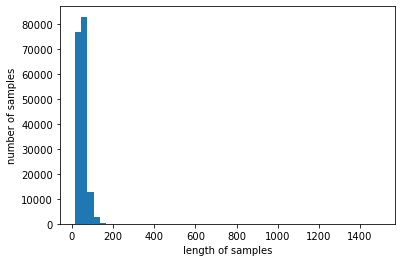

time: 736 ms (started: 2021-02-02 11:15:55 +09:00)


In [95]:
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in corpus], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에 히스토그램으로는 문장길이 분포를 살펴보기 어렵습니다. 히스토그램상에서 문장길이가 200이상인 경우가 대부분에 해당하는 것을 확인할 수 있기 떄문에 문장길이가 200이상인 문장에 대해서만 다시 한번 살펴봅니다.

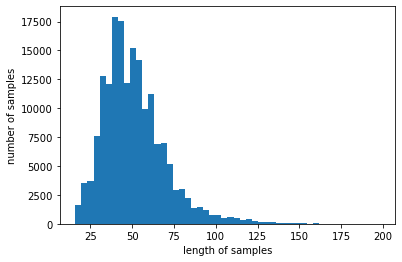

time: 704 ms (started: 2021-02-02 11:15:55 +09:00)


In [96]:
plt.hist([len(s)  for s in corpus if len(s)<200], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

반대로 문장길이가 200이상이고 최대길이에 해당하기까지의 문장 분포는 어떻게 될지 살펴봅시다. y축의 샘플의 개수를 확인해보면 앞선 히스토그램에서 17500에 비해, 25정도로 개수의 편차가 매우 큰 것을 알 수 있습니다. 

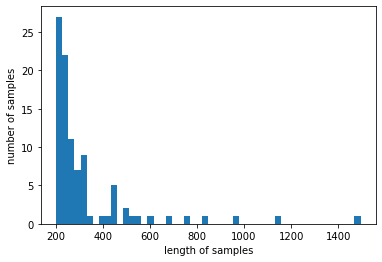

time: 176 ms (started: 2021-02-02 11:15:56 +09:00)


In [97]:
plt.hist([len(s)  for s in corpus if len(s)>200], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### Corpus 문장 길이 분포
* Corpus를 어떤 기준으로 padding해줄지에 대해서는 평균, 최대, 표준편차를 고려해줍니다.
* 왜? 평균 + 2*표준편차일까, 평균 + 표준편차는?정규분포의 지수적인 꼬리 부분에 해당하는 부분을 확인해보면 평균 + 표준편차는 약68%, 평균 + 2*표준편차는 약 95%입니다. 이러한 점을 통해 덜 극단적인 패딩의 최대 문장 길이를 선정할 수 있습니다.
* 출처: https://ko.wikipedia.org/wiki/68-95-99.7_%EA%B7%9C%EC%B9%99
~max_tokens = 15 # 문제에서는 15로 주어졌는데 왜일까? 확인해보면 매우.. 낮은데..!?~

In [98]:
max_tokens = np.mean(num_tokens) + np.std(num_tokens)

max_len = int(max_tokens)
print('pad_sequences maxlen: {}개'.format(max_len))
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen: 71개
전체 문장의 0.8801698702096089%가 maxlen 설정값 이내에 포함됩니다. 
time: 1.92 ms (started: 2021-02-02 11:15:57 +09:00)


--- 

#### **max_len은 몇으로 하는게 적당할까? 위에 나온 71개를 그대로 써도 괜찮을까?**    
>우리가 목표하고 있는 결과물은 작사가입니다. 일반적으로 패딩의 길이를 정해줄 때, 위와 같은 방법으로 히스토그램을 살펴본 후 가장 일반적인 길이를 선정해줍니다. 그래서 되도록 길이를 20 정도로 일반적인 노랫말들이 문장길이가 20정도 된다고 생각하고 max_len을 30으로 지정해주겠습니다. start와 end를 생각하면 글자 수는 10개 정도가 빠지는 거니까요  

In [99]:
# max_len = 30 

time: 188 µs (started: 2021-02-02 11:15:58 +09:00)


#### 문장길이 기준으로 데이터셋 축소 

In [100]:
len(corpus)

175899

time: 1.12 ms (started: 2021-02-02 11:15:59 +09:00)


In [101]:
corpus_thr = []

for sentence in corpus:
    if len(sentence) > 50: continue
        
    corpus_thr.append(sentence)
        
corpus_thr[:10]

["<start> i didn't mean to call you that <end>",
 "<start> i can't remember what was said <end>",
 '<start> please tell me why <end>',
 '<start> my car is in the front yard <end>',
 '<start> and i am sleeping with my cloths on <end>',
 '<start> and your . . . gone <end>',
 '<start> still buring please tell me why <end>',
 '<start> my car is in the front yard <end>',
 "<start> and i'm sleeping with my clothes on <end>",
 '<start> and your gone <end>']

time: 27.4 ms (started: 2021-02-02 11:16:00 +09:00)


In [102]:
len(corpus_thr)

96792

time: 1.33 ms (started: 2021-02-02 11:16:02 +09:00)


In [103]:
corpus = corpus_thr

time: 1.9 ms (started: 2021-02-02 11:16:02 +09:00)


In [104]:
max_len = 20

time: 256 µs (started: 2021-02-02 11:16:03 +09:00)


### 토큰화와 벡터화 ( + 패딩)
* keras를 활용해 데이터를 토큰화하고 단어 사전을 만들어 줍니다. 이 과정에서 데이터를 숫자로 인코딩해줍니다. 
* 여기서 index_word가 바로 단어 사전입니다. 말뭉치 -> 토큰화 -> 정수인코딩 -> 패딩의 과정을 거쳐 만들어집니다. 

#### 토크나이저의 단어사전 크기 설정: Counter
빈도수를 기준으로 자주 언급된 단어를 중심으로 데이터셋을 추릴 예정이다. 주로 자연어 처리에서 1번 언급된 문장은 제거해줍니다. 2번도 적은거 같아서 저는 여기서 3회 이상 언급된 문장만 살렸습니다. 

In [105]:
corpus[:10]

["<start> i didn't mean to call you that <end>",
 "<start> i can't remember what was said <end>",
 '<start> please tell me why <end>',
 '<start> my car is in the front yard <end>',
 '<start> and i am sleeping with my cloths on <end>',
 '<start> and your . . . gone <end>',
 '<start> still buring please tell me why <end>',
 '<start> my car is in the front yard <end>',
 "<start> and i'm sleeping with my clothes on <end>",
 '<start> and your gone <end>']

time: 1.51 ms (started: 2021-02-02 11:16:06 +09:00)


In [106]:
# Counter 사용 예시 
print(Counter(['hey jude', 'dont be afraid', 'hey jude', 'chorus', 'jyp', 'jyp']).most_common(3)) # 빈도수가 3이상인 글자만? (X), 빈도수 상위 3위까지 딕셔너리로 출력한다.

[('hey jude', 2), ('jyp', 2), ('dont be afraid', 1)]
time: 761 µs (started: 2021-02-02 11:16:06 +09:00)


In [107]:
counter = Counter(corpus)
counter_for_vocabsize = counter.most_common() # counter는 key인 글자와 value인 빈도수(등장횟수)로 이뤄져있다. 

counter_for_vocabsize[:10] # 앞에 10개만 

[('<start> chorus <end>', 204),
 ('<start> yeah <end>', 120),
 ('<start> come <end>', 85),
 ('<start> you nasty boy you nasty <end>', 84),
 ('<start> go , get ur freak on <end>', 60),
 ('<start> come on motherfuckers come on <end>', 48),
 ('<start> oh <end>', 46),
 ('<start> its bone and biggie biggie <end>', 46),
 ('<start> just bone and biggie biggie <end>', 44),
 ('<start> refrain <end>', 44)]

time: 32 ms (started: 2021-02-02 11:16:08 +09:00)


In [108]:
rare_cnt = 0

# # 빈도수를 1회 이상을 기준으로 잡아준다. 
for index in range(len(counter_for_vocabsize)):
    if counter_for_vocabsize[index][1] < 2: # 2회 이상
        rare_cnt = rare_cnt + 1

print("{}개의 2회 미만에 해당하는 단어가 있습니다.".format(rare_cnt))

vocab_size_ = len(corpus) - rare_cnt
print("vocab size는 {}개 입니다.".format(vocab_size_))

43533개의 2회 미만에 해당하는 단어가 있습니다.
vocab size는 53259개 입니다.
time: 9.25 ms (started: 2021-02-02 11:16:11 +09:00)


In [109]:
print("{}개의 글자 묶음에서 빈도수 상위 {}위에 속하는 단어만으로 단어사전을 만들었습니다".format(len(corpus), vocab_size_))

96792개의 글자 묶음에서 빈도수 상위 53259위에 속하는 단어만으로 단어사전을 만들었습니다
time: 554 µs (started: 2021-02-02 11:16:12 +09:00)


In [110]:
vocab = [key for key, _ in counter_for_vocabsize[:vocab_size_]]
corpus = vocab # 개수를 줄인 corpus
vocab[:10]

['<start> chorus <end>',
 '<start> yeah <end>',
 '<start> come <end>',
 '<start> you nasty boy you nasty <end>',
 '<start> go , get ur freak on <end>',
 '<start> come on motherfuckers come on <end>',
 '<start> oh <end>',
 '<start> its bone and biggie biggie <end>',
 '<start> just bone and biggie biggie <end>',
 '<start> refrain <end>']

time: 5.84 ms (started: 2021-02-02 11:16:12 +09:00)


### Tokenizer 
* tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환
```
ResourceExhaustedError: OOM when allocating tensor with shape[17920,10001] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]
```
단어 사전 크기에 해당하는 num_words에는 6만개로 한다면 현재 RTX 2070 GPU는 out of memory가 될 확률이 높습니다. 그래서 임의로 좀더 줄여주는 것이 좋습니다.    
그럼 위의 과정은 쓸모가 없어질까요? 그건 아니라고 생각됩니다. 빈도수가 많은 문장을 기준으로 살려뒀기 때문에 좀 더 일반적인 데이터셋이 됬다고 볼 수 있기 때문입니다.     

In [111]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words= 20000,  # 임의의 단어사전의 크기  
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 <unk> 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           maxlen = max_len, 
                                                           padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 425   3 ...   0   0   0]
 [  2  47   3 ...   0   0   0]
 [  2  65   3 ...   0   0   0]
 ...
 [  2 176   9 ...   0   0   0]
 [  2   8  53 ...   0   0   0]
 [  2 110  53 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f924b5304d0>
time: 921 ms (started: 2021-02-02 11:16:13 +09:00)


#### 패딩 확인
확인 결과 토큰나이저에서 정수인코딩이 <start>는 2로, <end> 토큰은 3으로 인코딩했음을 알 수 있습니다. 
0은 패딩이고 아마 1은 unk 토큰일듯합니다. 

In [112]:
print(len(tensor))
print(tensor[:10, :10])

53259
[[   2  425    3    0    0    0    0    0    0    0]
 [   2   47    3    0    0    0    0    0    0    0]
 [   2   65    3    0    0    0    0    0    0    0]
 [   2    7 1042  174    7 1042    3    0    0    0]
 [   2   48    4   43 1793 1322   18    3    0    0]
 [   2   65   18 1178   65   18    3    0    0    0]
 [   2   37    3    0    0    0    0    0    0    0]
 [   2  134  939    8  915  915    3    0    0    0]
 [   2   31  939    8  915  915    3    0    0    0]
 [   2 4637    3    0    0    0    0    0    0    0]]
time: 953 µs (started: 2021-02-02 11:16:13 +09:00)


## 4. 데이터셋 분리 

In [113]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[  2 425   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[425   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]
time: 1.07 ms (started: 2021-02-02 11:16:14 +09:00)


### 데이터셋 분리 
데이터셋을 분리할 때 주의할 점은 우리가 텐서플로우를 사용한다면 입력은 텐서인 편이 더 잘 동작한다는 점입니다. 사이킷런의 train_test_split을 쓰면 그에 대한 타입을 확인헀을때 numpy.ndarray임을 확인할 수 있습니다. 그래서 이후에 텐서 데이터셋 객체로 변환해주는 작업을 진행합니다. 노드에서는 해당 순서가 반대로 되어 설명되어 있습니다.(?!)

In [121]:
X_train, X_val, y_train, y_val = train_test_split(src_input,
                                                  tgt_input,
                                                  test_size = 0.2,
                                                  shuffle = True
                                                 )

print("Source Train: ", X_train.shape)
print("Target Train: ", y_train.shape)
print("Source Test: ", X_val.shape)
print("Target Test: ", y_val.shape)

Source Train:  (42607, 19)
Target Train:  (42607, 19)
Source Test:  (10652, 19)
Target Test:  (10652, 19)
time: 9.12 ms (started: 2021-02-02 11:22:21 +09:00)


In [122]:
type(X_train)

numpy.ndarray

time: 1.2 ms (started: 2021-02-02 11:22:21 +09:00)


### Hyper-parameter

In [123]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
VALIDATION_STEPS = len(X_val) // BATCH_SIZE
# steps_per_epoch = len(src_input) // BATCH_SIZE

time: 603 µs (started: 2021-02-02 11:22:22 +09:00)


**하이퍼 파라미터에 vocab size도 추가요~**     
위에서 Train set을 살펴보면 개수가 4만개 정도 됩니다. 나중에 단어사전 크기는 모델의 인자로서 쓰이며 우리가 몇개의 단어로 이뤄진 사전을 참고할지를 결정합니다. 그래서 Train 개수보다 너무 작지 않은 크기로 설정해줍니다. 하지만 너무 크게 잡아도 속도 측면에서 비효율적일 수 있습니다.

In [124]:
print(tokenizer.num_words)
VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

20000
time: 371 µs (started: 2021-02-02 11:23:03 +09:00)


### 데이터셋 객체로 변환
* tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환

In [125]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE, drop_remainder=True)
test_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(BUFFER_SIZE)
test_data = test_data.batch(BATCH_SIZE, drop_remainder=True)
train_data, test_data

(<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>,
 <BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>)

time: 21.8 ms (started: 2021-02-02 11:23:04 +09:00)


## 5. 모델 설계 및 학습
Subclassing 방식으로 설계한 모델을 만들어봅니다. 

#### Hyper-parameter

In [126]:
vocab_size = VOCAB_SIZE
embedding_size = 256 # 단어가 추상적으로 표현되는 크기로서 CNN으로 생각하면 몇개의 특징을 추출할지 결정하는 인자입니다. 
hidden_size = 1024

time: 348 µs (started: 2021-02-02 11:23:08 +09:00)


In [127]:
class TextGenerator(tf.keras.Model):
    def __init__(self, _vocab_size, _embedding_size, _hidden_size):
        super(TextGenerator, self).__init__()
        
        # 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔줍니다. 
        self.embedding = tf.keras.layers.Embedding(_vocab_size, _embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(_hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(_hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(_vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

model = TextGenerator(vocab_size, embedding_size , hidden_size) # 단어 사전의 크기 tokenizer.num_words + 1

time: 13.2 ms (started: 2021-02-02 11:23:09 +09:00)


In [128]:
for src_sample, tgt_sample in train_data.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 19, 20001), dtype=float32, numpy=
array([[[-1.41869368e-05, -1.85266363e-05,  1.48976091e-04, ...,
          2.50472658e-04,  3.34706565e-05, -2.21044029e-05],
        [ 3.64154839e-05,  6.70620793e-05,  2.49300734e-04, ...,
          4.11134853e-04,  3.60025988e-05, -4.15258546e-05],
        [ 1.21329838e-04,  3.85174848e-04,  3.55860771e-04, ...,
          2.93055462e-04,  1.15178365e-04, -3.58557241e-04],
        ...,
        [-1.37751584e-03, -6.08289964e-04,  6.15724362e-04, ...,
         -1.21264791e-04, -1.29209971e-03,  2.08315774e-04],
        [-1.53752544e-03, -6.85541716e-04,  7.04923645e-04, ...,
         -1.29664157e-04, -1.42409233e-03,  3.61977698e-04],
        [-1.68615743e-03, -7.50966661e-04,  7.75373483e-04, ...,
         -1.37051233e-04, -1.54645112e-03,  5.02716692e-04]],

       [[-1.41869368e-05, -1.85266363e-05,  1.48976091e-04, ...,
          2.50472658e-04,  3.34706565e-05, -2.21044029e-05],
        [-1.55847403e-04,  3.78088880e-05,  2

time: 4.18 s (started: 2021-02-02 11:23:09 +09:00)


In [129]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  5120256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  20501025  
Total params: 39,260,961
Trainable params: 39,260,961
Non-trainable params: 0
_________________________________________________________________
time: 1.27 ms (started: 2021-02-02 11:23:13 +09:00)


### Hyper-parameter 
목표하는 val_loss는 2.2% 수준으로 낮춰야한다. 

In [130]:
# BUFFER_SIZE = len(src_input)
# BATCH_SIZE = 256
# steps_per_epoch = len(src_input) // BATCH_SIZE
# 위에서 데이터셋 텐서로 바꿔줄 때 이미 정의한 파라미터들 

MAX_EPOCHS = 10
LEARNING_RATE = 1e-3 # 1e-4 => 1e-3

time: 8.79 ms (started: 2021-02-02 11:23:13 +09:00)


### 모델 학습 

In [131]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
cp_callback = tf.keras.callbacks.ModelCheckpoint(chkpnt_path + '/lyrics',
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

time: 421 µs (started: 2021-02-02 11:23:13 +09:00)


In [132]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

time: 459 µs (started: 2021-02-02 11:23:13 +09:00)


In [133]:
model.compile(loss=loss, optimizer=optimizer,
             metrics=['accuracy'])
hist_model = model.fit(train_data, 
                       steps_per_epoch = STEPS_PER_EPOCH,
                       validation_data = test_data, 
                       validation_steps = VALIDATION_STEPS,
                       epochs= MAX_EPOCHS,
                      callbacks = [es, cp_callback])

Epoch 1/10
166/166 [==============================] - ETA: 0s - loss: 2.6057 - accuracy: 0.6740
Epoch 00001: val_loss improved from inf to 2.04457, saving model to /home/aiffel-dj19/aiffel/lyricist/models/chkpnt/lyrics
166/166 [==============================] - 54s 323ms/step - loss: 2.6057 - accuracy: 0.6740 - val_loss: 2.0446 - val_accuracy: 0.7152
Epoch 2/10
166/166 [==============================] - ETA: 0s - loss: 1.9889 - accuracy: 0.7149
Epoch 00002: val_loss improved from 2.04457 to 1.98011, saving model to /home/aiffel-dj19/aiffel/lyricist/models/chkpnt/lyrics
166/166 [==============================] - 52s 311ms/step - loss: 1.9889 - accuracy: 0.7149 - val_loss: 1.9801 - val_accuracy: 0.7177
Epoch 3/10
166/166 [==============================] - ETA: 0s - loss: 1.9042 - accuracy: 0.7175
Epoch 00003: val_loss improved from 1.98011 to 1.93724, saving model to /home/aiffel-dj19/aiffel/lyricist/models/chkpnt/lyrics
166/166 [==============================] - 50s 300ms/step - loss: 1

### 학습 결과 시각화 

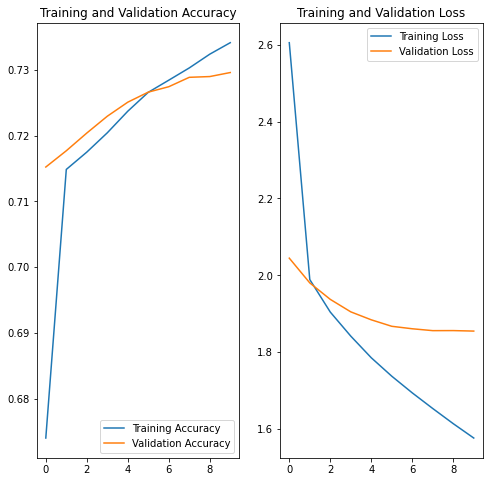

time: 211 ms (started: 2021-02-02 11:31:35 +09:00)


In [134]:
acc = hist_model.history['accuracy']
val_acc = hist_model.history['val_accuracy']

loss=hist_model.history['loss']
val_loss=hist_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. 모델 Test

In [135]:
model.load_weights(chkpnt_path + '/lyrics')
results = model.evaluate(X_val, y_val)[1]

333/333 [==============================] - 6s 19ms/step - loss: 1.8550 - accuracy: 0.7296
time: 6.98 s (started: 2021-02-02 11:31:35 +09:00)


In [136]:
def generate_text(_model, _tokenizer, init_sentence="<start>", _max_len=25):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = _tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = _tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = _model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
        tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, _max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= _max_len: break

    generated = ""
    
    # 생성된 tensor 안에 있는 word index를 _tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += _tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

time: 678 µs (started: 2021-02-02 11:31:42 +09:00)


In [56]:
result_txt = generate_text(model, tokenizer, init_sentence="<start> i love")
len(result_txt)

'<start> i love you to be <end> '

time: 46.9 ms (started: 2021-02-02 09:31:29 +09:00)


## 7. 루브릭
* 가사 텍스트 생성 모델이 정상적으로 동작하는가?
    - 텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?

* 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?
    - 특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?

* 텍스트 생성모델이 안정적으로 학습되었는가?
    - 텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?

### 텍스트 제너레이션 결과 

In [53]:
generate_text(model, tokenizer, init_sentence="<start> Love to")

'<start> love to be the same <end> '

time: 30.8 ms (started: 2021-02-02 09:24:55 +09:00)


In [54]:
generate_text(model, tokenizer, init_sentence="<start> Just before")

'<start> just before you are <end> '

time: 21.9 ms (started: 2021-02-02 09:24:55 +09:00)


### 전처리 테스트
전처리는 위에서, data_preprocessing과 tokenizer 함수를 통해 특수문자 제거, 토크나이저 생성, 패딩처리를 적절히 진행했습니다.

### 모델 학습 결과
|parameters|accuracy|loss|
|:--------:|:------:|:--:|
|vocab_size=15000, max_len=30|0.7146|1.8715|

## 8. 회고 

### 어려웠던 점
* Class, 객체지향..!!.. 두둥..
지금까지는 주로 모델을 설계할때 Sequential에 입출력을 쭉 쌓아가는 방식을 이용했는데 이번에는 클래스를 활용해서 모델을 설계해본 점이 어려웠습니다. 그래서 아는 선에서 주석으로 코드를 한줄씩 해석해봤습니다.
     
```
# tf.keras.Model를 부모클래스로 두는 TextGenerator 클래스 객체를 선언
class TextGenerator(tf.keras.Model): 

    # __init__ 메소드(= 생성자)를 통해 객체 초기화 
    def __init__(self, _vocab_size, _embedding_size, _hidden_size):
    
        # 부모클래스 기준으로 변수 초기화 
        super(TextGenerator, self).__init__() # super().__init__()와 동일 
        
        # 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔줍니다. 
        # self는 객체의 인스턴스를 의미
        self.embedding = tf.keras.layers.Embedding(_vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(_hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(_hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(_vocab_size)
        
    # 호출될 때 자동 실행되는 메소드 
    # Training할지 Evaluate할지 결정하기도 함.
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
```
    
위에서 상속받은 model 클래스의 특징은 다음과 같습니다. 
> Model 클래스는 Layer와 같은 API를 가지며, 다음과 같은 차이점이 있습니다.
내장 훈련, 평가 및 예측 루프( model.fit() , model.evaluate(), model.predict())를 제공합니다.
model.layers 속성을 통해 내부 레이어의 목록을 노출합니다.
저장 및 직렬화 API(save(), save_weights()...)를 노출합니다.
    
따라서, fit과 save를 사용할 예정이라면 Model 클래스를 사용해야하고 이외에는 Layer클래스를 상속받아도 괜찮습니다.  
     
     
* 문제점들.. 단어로 끊어져서 나오는 현상? 뭔가 반복된 단어만 나오는 현상 
```
'<start> i love you the t the be <end> '
```
결과를 확인할 때 완성된 단어보다 알파벳 하나씩 Generate되는 문제가 있었습니다. 입력을 바꾸더라도 같은 단어만 반복적으로 나타나는 것을 알 수 있습니다. 
```
'<start> wow , the t a t a t <end> '
'<start> lemon tree , the t a t a t <end> '
'<start> hey hey , i m a t <end> '
```
단어가 반복되서 나오는 현상    
```
'<start> its just the the the the the the <end> '
```
'd, 've, 'm과 같은 '를 기준으로 쪼개진 알파벳이 많아서 이러한 결과가 나오는거 같아서 전처리 단계에서 특수문자 중 '는 제거하지 않도록 했습니다. 
    
    
 * 특정 공백 문장이 안 사라지는 현상 
 ``` 
 ['<start> chorus <end>',
 '<start> yeah <end>',
 '<start> come <end>',
 '<start>  <end>',
 '<start> oh <end>',
 '<start> refrain <end>',
 '<start> verse <end>',
 '<start> michael <end>',
 '<start> oh yeah <end>',
 '<start> check it out <end>']
 ```
위에서 3번째 문장이 계속 공백이 안사라졌습니다. 어떤 문자값이 들어가있는지 모르겠습니다. (=> 해결하지 못한 부분)

### 추가시도 

* padding에서 평균과 표준편차 활용해서 80% 데이터를 포함하는 최대문장길이를 살펴봤습니다. (padding 코드 쪽)    

* Counter 모듈을 활용해서 단어사전의 크기를 결정해줬습니다. 하지만, 메모리 부족으로 사이즈를 줄여줘야했습니다. (토크나이저 이전단계 쪽)
    
* 문장의 길이가 30 이하인 텍스트 데이터로만 데이터셋을 구성해봤습니다.     
일단 글자수를 제한해두고 데이터셋을 다시 구축했더니 약 7천개의 데이터로 개수가 확 줄었습니다. 그래서 단어 사전 크기도 그에 맞게 5000개 정도로 설정했습니다. 정확도나 손실을 봤을때는 더 증가하지만, 예측했을때 결과가 나오지 않았습니다.   

|                    |accuracy|loss|
|:------------------:|:------:|:--:|
|전체 문장길이 30으로 패딩|0.7146|1.8715|  
|30초과 삭제 후 20으로 패딩|0.8157|1.2610|    

* 사전의 크기는 영향이 클까?   
각 노드별로 설정하는 단어사전의 크기가 다름을 알 수 있습니다. 단어사전의 크기는 주로 사용자의 자원 상황에 따라 선택적인 요소인지, 정확도에도 큰 영향을 줄지 확인해봤습니다. 단어사전의 크기를 크게했을 때는 학습속도가 매우 느려졌습니다. 그리고 크기가 정확도 개선 측면에서 큰 영향이 없음을 확인할 수 있었습니다. 하지만 데이터 전체개수가 작아질 수록 단어사전의 크기를 5000 정도로 줄이니 결과값이 t the 등 특정갑이 반복해서 나타나는 현상이 있었습니다. 그래서 데이터를 길이 30을 기준으로 받아오고 20을 기준으로 길이 제한을 두었습니다. 그 결과 노래 가사를 만들어낼 수 있었습니다.

|vocab size|accuracy|loss|
|:--------:|:------:|:--:|
|15,000|0.7146|1.8715|
|50,000|0.7173|1.9198|  

### 시도해보지 못한 점
* 유사도가 비슷한 단어들을 생성하면 좀 더 자연스러울까?   
노래도 장르나 담고 있는 내용이 다르듯이 유사도가 비슷한 문장끼리 생성하면 더 자연스러운 노랫말을 만들 수 있을지 않으까하는 생각을 했지만 시간이 부족해 시도해보진 않았습니다. 기회가 된다면 유사도를 활용해서 분위기가 그럴싸한 노랫말을 만들어낼 수 있는지 확인해보고 싶습니다. 

### 결과에 대한 고찰 
* 왜 t가 학습됐을까?    
    
```
generate_text(model, tokenizer, init_sentence="<start> i love")

```    

위에서 결과가 '<start> i love you the t the be <end> '로 나옵니다.    
처음 학습 모델의 결과는 you the t the be를 생성했습니다. t가 뜬금없다는 생각이 들었는데 데이터를 살펴보니, 가삿말에는 don't처럼 t는 특수문자 뒤에 혼자 올 수 있는 상황들이 있었습니다. a나 t, d, ve처럼 ' 뒤에 알파벳 하나가 오는 경우가 학습되기 때문에 발생할 수 있는 부분이라고 생각됩니다.     
이러한 경우 때문에 글자길이가 1인 문자를 공백으로 치환하기에는 케이스가 다양하고 가삿말에는 은유적인 표현이 있을 수 있기 떄문에 그대로 진행했습니다.     
    
* 정확도만 개선되면 프로젝트 성능이 더 좋아졌다고 볼 수 있을까?   
정확도 개선도 중요하지만 무엇을 predict하는지 예측 결과를 확인하는 작업도 꼭 하는 것이 좋다는 것을 배울 수 있었습니다. 

### 배운 점과 자기 다짐 
* 토큰화는 상대적이다는 점을 확실하게 알 수 있었습니다.    
처음에 문제에서 문장 길이를 20으로 해주라고 하는 가정을 봤을때에는 데이터셋을 다 포괄적으로(90% 정도) 포함도 못 하는데 왜 max_len을 20으로 해주는게 좋은건지 이해가 어려웠는데, 작사가라는 프로젝트 특성을 고려 못했다는 것을 깨달았습니다. 실제로 90%를 차지하는 문장길이는 71 정도라도 프로젝트의 목적이 가사를 만들어내는 것이기 때문에 한 문장길이가 70은 너무 길기 때문에 부적절했습니다. 이를 통해서 토큰화는 프로젝트의 특성에 맞게 진행해줘야 한다는 점을 알 수 있었습니다. 

* GPT? 
GPT에 대해서는 잘 몰랐는데 해당 부분을 블로그로 정리하면 NLP가 단순히 말을 해석하는거 뿐만 아니라 새로운 문장을 만들어내고 창작활동에도 쓰이는 사례들을 볼 수 있을거같아 관련해서 블로그로 정리해보기로... 다짐합니다..!